In [1]:
#| hide
import sys
sys.path.append('../.venv/lib/python3.9/site-packages/')

# Salience Reaction to Image Noise

### From Colton R. Crum

In [2]:
import torch

## Necessary Arguments

In [3]:
model_path = "../models/weights/Densenet/densenet_cyborg_1/Logs/final_model.pth"
network = "densenet"
dataset = "../data/images/ffhq_aligned/00001.png"

amount = 0.05

In [4]:
device = torch.device('cpu')

## Load The Model

In [5]:
import torchvision.models as models
import torch.nn as nn

Load weights of single binary DesNet121 model

In [6]:
weights = torch.load(model_path, map_location=device)

In [97]:
if network == "resnet":
    im_size = 224
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif network == "inception":
    im_size = 299
    model = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif network == "xception":
    im_size = 299
    model, *_ = model_selection(modelname='xception', num_out_classes=2)
else: # else DenseNet
    im_size = 224
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 2)

In [98]:
#| output: false
model.load_state_dict(weights['state_dict'])
model = model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
sigmoid = nn.Sigmoid()

## Preprocessing

In [13]:
import torchvision.transforms as transforms

In [14]:
if network == "xception":
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
else:
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

## Get Original Prediction

In [15]:
import skimage.io
from PIL import Image

In [16]:
predictions = []

Read the image

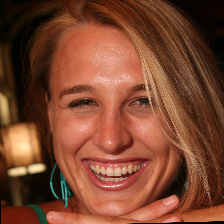

In [17]:
image = skimage.io.imread(dataset)
image = Image.fromarray(image)
image

Model Preprocessing

In [18]:
tranformImage = transform(image)
tranformImage = tranformImage[0:3,:,:].unsqueeze(0)
tranformImage = tranformImage.to(device)

Get Prediction from Model

In [19]:
with torch.no_grad():
    output = model(tranformImage)

In [20]:
PAScore = round(sigmoid(output).detach().cpu().numpy()[:, 1][0], 3)
predictions.append(PAScore)
print(PAScore)

0.781


## Getting Prediction of Noisy Image

In [21]:
import numpy as np

Read the Image

In [22]:
image_np = skimage.io.imread(dataset)

Generate Random Noise

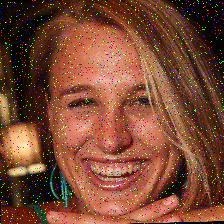

In [23]:
salt_pepper = skimage.util.random_noise(image_np, mode='s&p', amount=amount)
salt_pepper = np.array((salt_pepper * 255).astype(np.uint8))
salt_pepper = Image.fromarray(salt_pepper)
salt_pepper

Model Preprocessing

In [24]:
tranformImage = transform(salt_pepper)
tranformImage = tranformImage[0:3,:,:].unsqueeze(0)
tranformImage = tranformImage.to(device)

Get Prediction From Model

In [25]:
with torch.no_grad():
    output = model(tranformImage)

In [26]:
PAScore = round(sigmoid(output).detach().cpu().numpy()[:, 1][0], 3)
predictions.append(PAScore)
print(PAScore)

0.016


## Display Both Images

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

/tmp/ipykernel_2454979/759221647.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


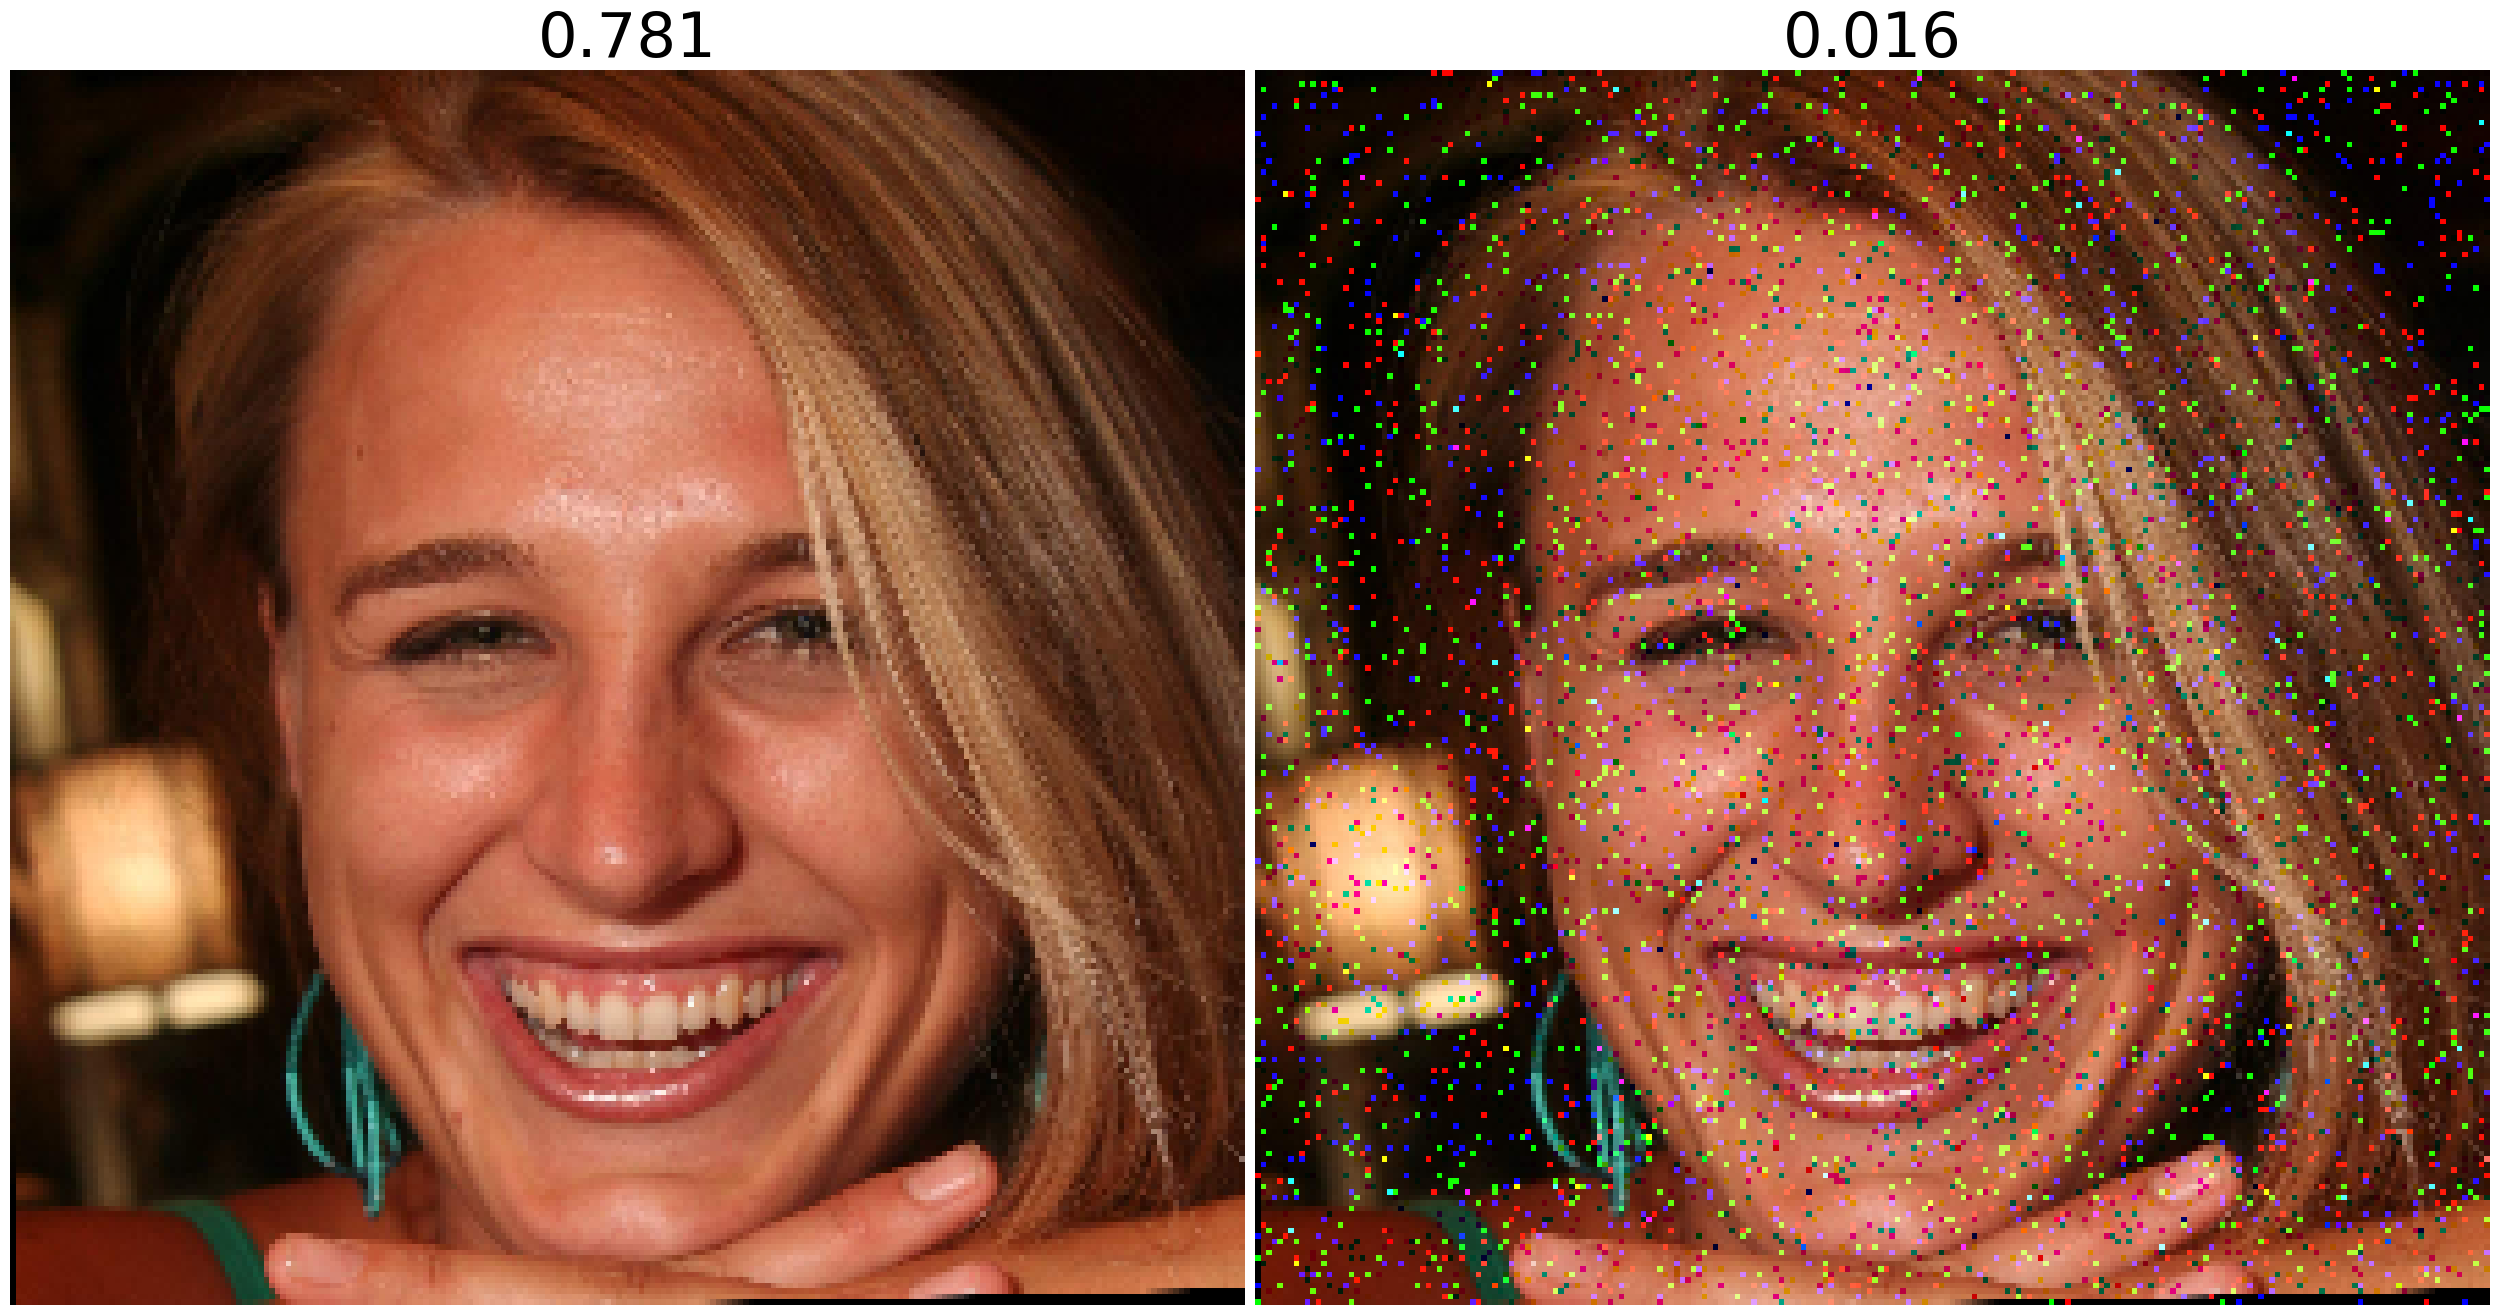

In [28]:
fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for index, (ax, im) in enumerate(zip(grid, [image, salt_pepper])):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.grid(b=None)
    ax.imshow(im)
    ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
#plt.savefig("noise-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)
plt.show()

## Save Results

### Save PAScores to JSON

In [112]:
import json

In [116]:
scores = {
    "original": str(predictions[0]),
    "noise": str(predictions[1]),
}

In [117]:
with open("../output/metrics/noise", "w") as file:
    json.dump(scores, file)

In [94]:
salt_pepper.save('../output/images/s&p.png')

## Creating GradCAM

In [51]:
from PIL import Image
from torchcam.methods import GradCAM
from torchcam.methods import GradCAMpp
import skimage.io

Transform the Image

In [95]:
image_tensor = transform(salt_pepper)

Creating the Grad-Cam

In [99]:
cam_extractor = GradCAM(model)

## Processing GradCAM

In [34]:
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

Preprocess your data and feed it to the model

In [100]:
out = model(image_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

Retrieve the CAM by passing the class index and the model output

In [101]:
cam = to_pil_image(activation_map[0].squeeze(0), mode='F')

In [106]:
cam = overlay_mask(salt_pepper, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.50)

In [107]:
cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)

/tmp/ipykernel_2454979/4214749104.py:1: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)


## Displaying GradCAM

/tmp/ipykernel_2454979/48172873.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


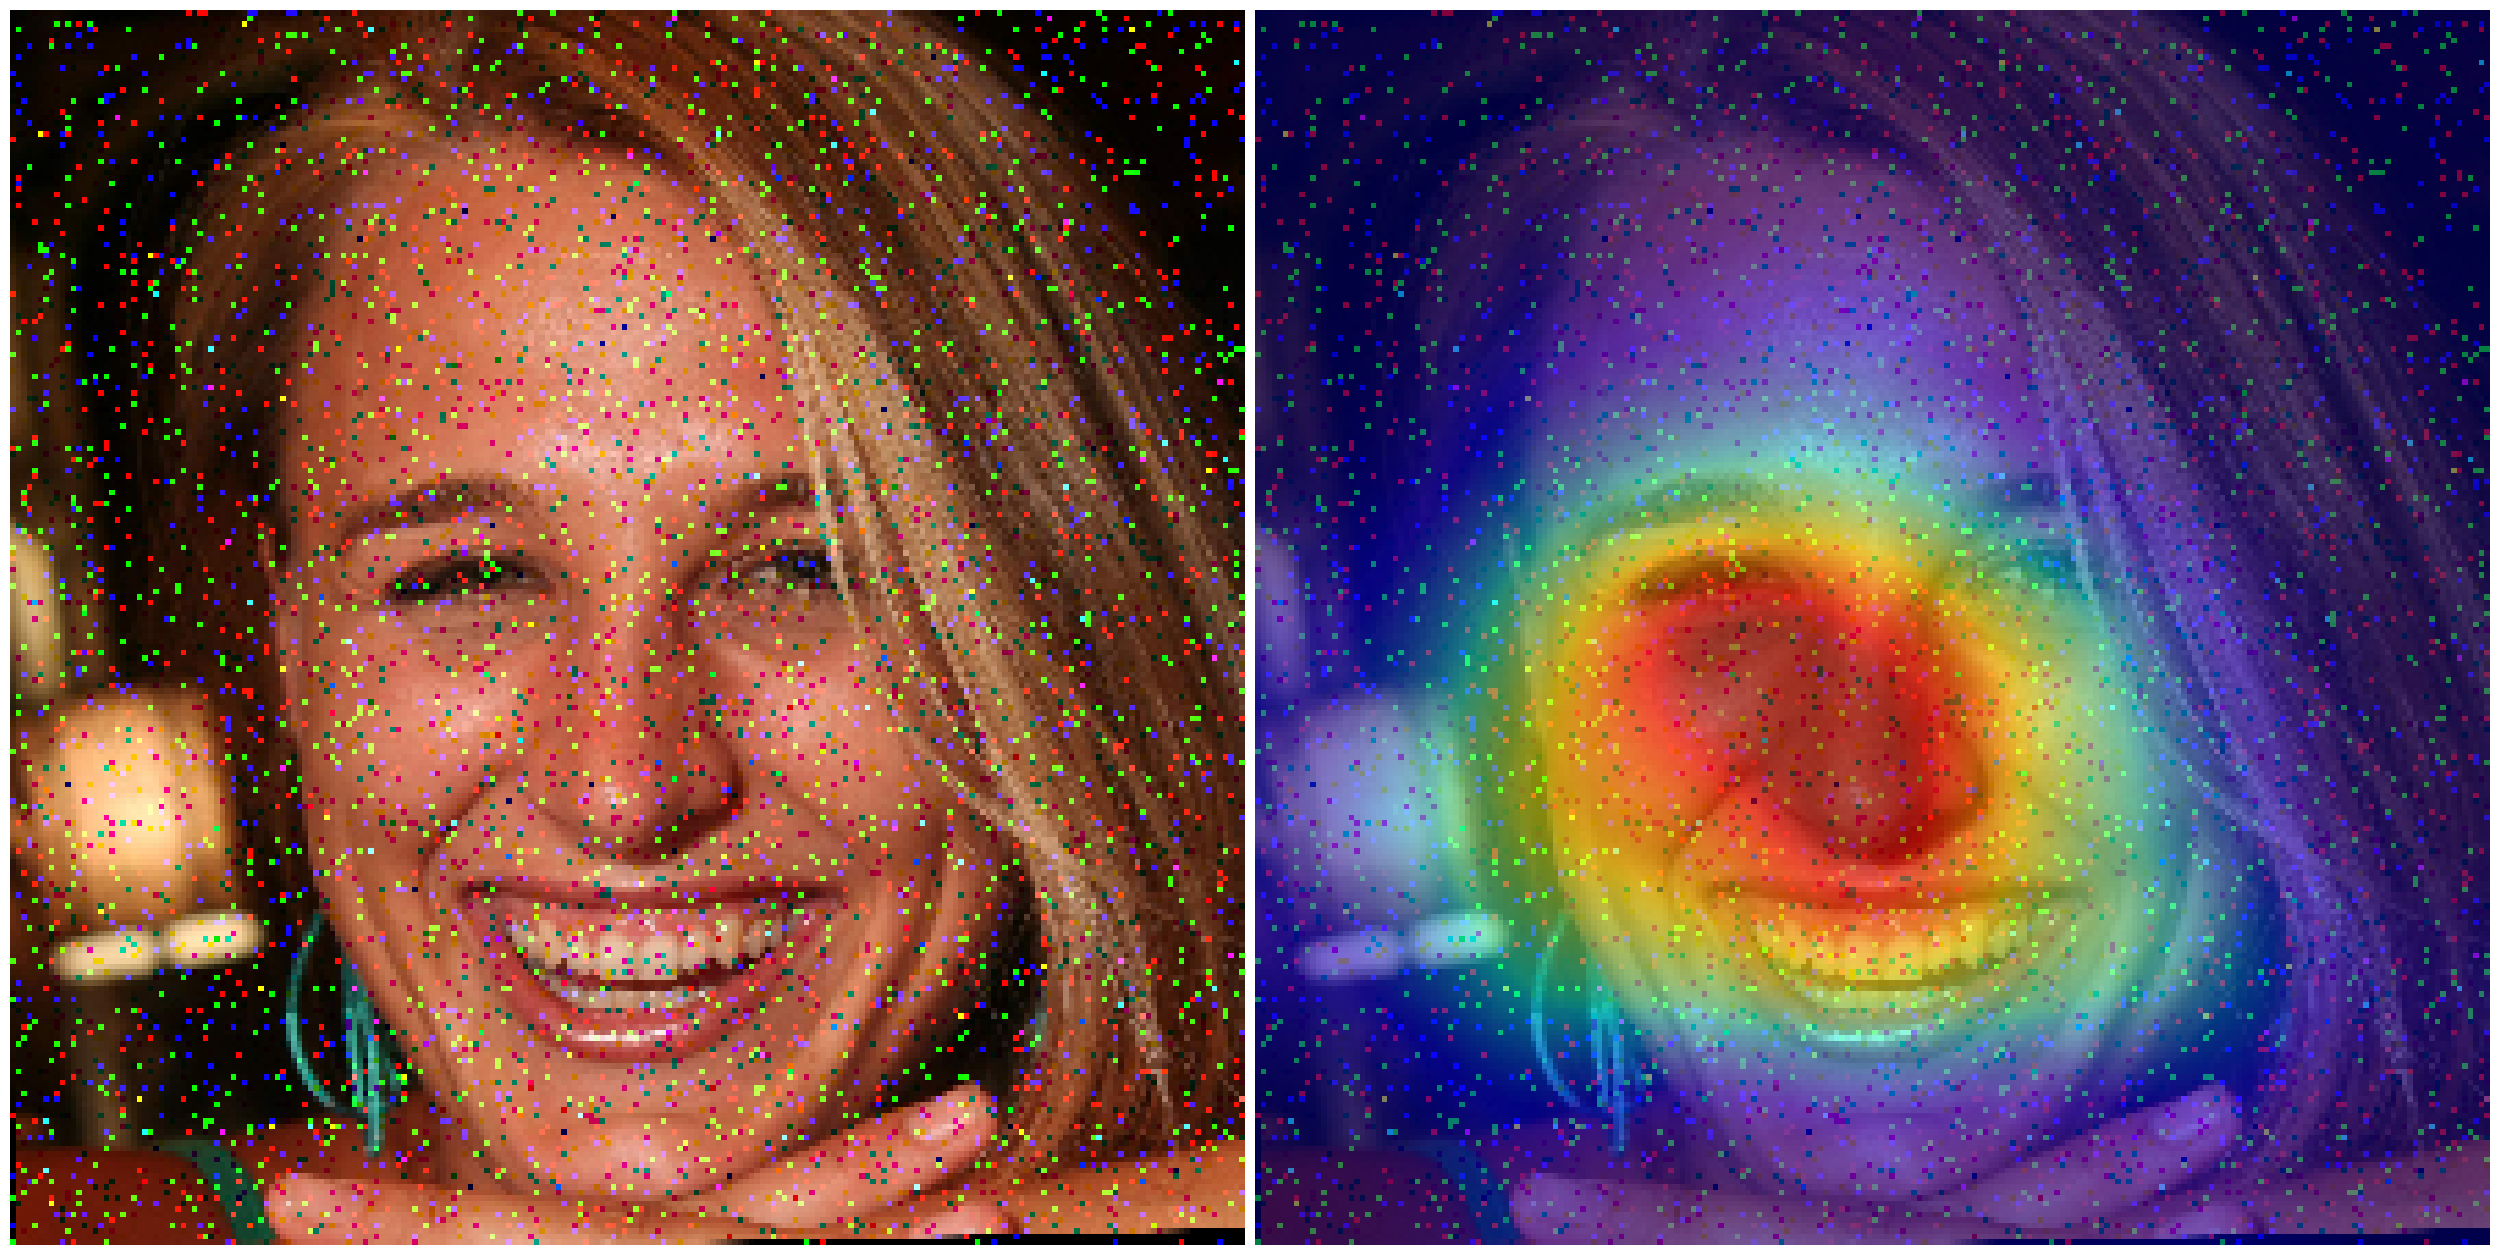

In [108]:
fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=1.2
                 )

for index, (ax, im) in enumerate(zip(grid, [salt_pepper, cam])):
    ax.axis('off')
    ax.grid(b=None)
    ax.imshow(im)
    #ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
#plt.savefig("entropy-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)
fig.set_size_inches(32, 18)
plt.show()

                                            